# ISLR- Python Ch6 -- Lab 2: Ridge Regression and the Lasso

- [Load Hitters Dataset](#Load-Hitters-Dataset)
- [6.6.1 Ridge Regression](#6.6.1-Ridge-Regression)
    - [Plot Regression Coeffecients vs Ridge Penalty](#Plot-Regression-Coeffecients-vs-Ridge-Penalty)
    - [Use Validation And Cross Validation to Estimate Test MSE](#Use-Validation-And-Cross-Validation-to-Estimate-Test-MSE )
- [6.6.2 The Lasso](#6.6.2-The-Lasso)
    - [Plot Regression Coeffecients vs Lasso Penalty](#Plot-Regression-Coeffecients-vs-Lasso-Penalty)
    - [Use Cross Validation to Estimate Test MSE](#Use-Cross-Validation-to-Estimate-Test-MSE )

In [1]:
# perform standard imports
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn import cross_validation
from sklearn.cross_validation import KFold
from matplotlib import pyplot as plt
from operator import itemgetter

%matplotlib inline
plt.style.use('ggplot') # emulate R's pretty plotting

# print numpy arrays with precision 4
#np.set_printoptions(precision=4)

## Load Hitters Dataset

In [2]:
# In Lab 1 we explored the hitters dataframe locating rows with missing data and identifying
# categorical variables. See that lab for details...
hitters = pd.read_csv('../../data/Hitters.csv', index_col=0).dropna()

# Create a set of dummy variables for the categoricals
dummies = pd.get_dummies(hitters[['League', 'Division', 'NewLeague']])

# Generate new dataframe with new dummy variables
hitters = hitters.drop(['League', 'Division', 'NewLeague'], axis=1)

# add new dummy variables to hitters
hitters = pd.concat([hitters, dummies[['League_N', 'Division_W', 'NewLeague_N']]],axis=1)

hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0,1,1,1
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0,0,1,0
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0,1,0,1
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5,1,0,1
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0,0,1,0


## 6.6.1 Ridge Regression

In Ridge Regression, we seek to minimize an objective function of the form:

$\sum_{i=1}^{N}{\left(y_i-\beta_0-\sum_{j=1}^{p}{\beta_jx_{i,j}}\right)}^2+\lambda\|\beta_j\|_2^2$. 

** R's GLMNET with $\bf{\alpha=0}$ minimizes the following:** (see https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html and https://core.ac.uk/download/files/153/6287975.pdf)

$\min \left(\frac{1}{2N}\sum_{i=1}^{N}{\left(y_i-\beta_0-\sum_{j=1}^{p}{\beta_jx_{i,j}}\right)}^2+\frac{\lambda}{2}\|\beta_j\|_2^2\right)$

** SKLEARN.RIDGE minimizes:** (see http://scikit-learn.org/stable/modules/linear_model.html#ridge-regression)

$\min \left(\sum_{i=1}^{N}{\left(y_i-\beta_0-\sum_{j=1}^{p}{\beta_jx_{i,j}}\right)}^2+\alpha\|\beta_j\|_2^2\right)$

From the above we can see that **glmnet uses the mean-squared error** and **sklearn minimizes the total squared error** To compare the two algorithms we would need to convert both lamdas and alphas to degrees of freedom (see Elements of Statistical Learning page 68). This involves computing the Singular Value Decomposition of the design matrix for hitters. The diagonal of this matrix has eigenvalues that determine the amount of shrikage for each predictor coeffecient. ** Upto this eigenvalue, sklearn's alpha is proportional to lambda/2N ** You can see this in the above equations by factoring out N. That is what we will do here. This will get us pretty close to glmnets coeffecients.

In [3]:
# Get the predictors and response from hitters
X = hitters.drop('Salary', axis = 1)
y = hitters.Salary


# list to hold our regression models
regr = []

alphas = 10**np.linspace(10,-2,100)/(2*len(X))

# build models
for index, alph in enumerate(alphas):
    
    # NOTE normalize = True does not standardize the regressors by standard deviation, it divides by
    # the l2 norm of each column. This will lead to some differences with glmnet results.
    model = Ridge(alpha=alph, normalize=True)
    
    regr = np.append(regr, model.fit(X,y))

# show the alpha in sklearn and the corresponding lambda in glmnet
print('sklearn alpha =', regr[49].alpha, ' ~ glmnet lambda = ', regr[49].alpha*2*len(X),'\n')  

# make a datframe of the results
df = pd.Series(data = np.hstack([regr[49].intercept_, regr[49].coef_]),
               index=['Intercept'] + X.columns.tolist())

print(df,'\n')

print('l2 norm of Betas=', np.sqrt(sum(df.apply(lambda x: x**2).iloc[1:])))

sklearn alpha = 21.8584980114  ~ glmnet lambda =  11497.569954 

Intercept      390.991665
AtBat            0.041620
Hits             0.156398
HmRun            0.588092
Runs             0.260571
RBI              0.270224
Walks            0.327661
Years            1.240185
CAtBat           0.003522
CHits            0.013129
CHmRun           0.098564
CRuns            0.026339
CRBI             0.027196
CWalks           0.028085
PutOuts          0.018872
Assists          0.002974
Errors          -0.025042
League_N         0.179995
Division_W      -7.167844
NewLeague_N      0.404765
dtype: float64 

l2 norm of Betas= 7.33114679536


In [4]:
# Now again for glmnet lambda 705
# show the alpha in sklearn and the corresponding lambda in glmnet
print('sklearn alpha =', regr[59].alpha, ' ~ glmnet lambda = ', regr[59].alpha*2*len(hitters),'\n')  

# make a datframe of the results
df = pd.Series(data = np.hstack([regr[59].intercept_, regr[59].coef_]), index=['Intercept'] + X.columns.tolist())

print(df,'\n')

print('l2 norm of Betas=', np.sqrt(sum(df.apply(lambda x: x**2).iloc[1:])))

sklearn alpha = 1.34121716934  ~ glmnet lambda =  705.480231072 

Intercept      43.153507
AtBat           0.108824
Hits            0.692671
HmRun           1.096491
Runs            0.967662
RBI             0.860228
Walks           1.381808
Years           2.440718
CAtBat          0.011040
CHits           0.048801
CHmRun          0.351160
CRuns           0.097495
CRBI            0.102084
CWalks          0.070088
PutOuts         0.127957
Assists         0.017939
Errors         -0.815896
League_N       15.294486
Division_W    -59.507619
NewLeague_N     9.047403
dtype: float64 

l2 norm of Betas= 62.2013128001


Notice the larger l2 norm when lambda is smaller (i.e. the coeffecient shrinkage is less).

## Plot Regression Coeffecients vs Ridge Penalty

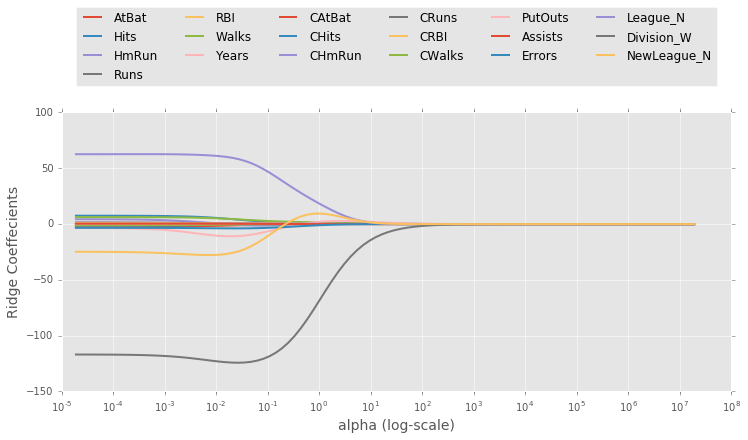

In [5]:
# We can make a plot of each of the ridge regression coeffecients as a function of the shrinkage factor alpha
ridge_coefs = np.empty((len(alphas),X.shape[1]))

# get standardized coeffs for each model
for index, model in enumerate(regr):
    ridge_coefs[index] = model.coef_[np.newaxis]
# Construct plot    
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(alphas,ridge_coefs, linewidth =2.0);
ax.set_xscale('log')
ax.set_xlabel('alpha (log-scale)', fontsize=14)
ax.set_ylabel('Ridge Coeffecients', fontsize=14)
ax.legend(X.columns.tolist(),loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=6);

## Use Validation And Cross Validation to Estimate Test MSE

In [6]:
# MSE- Validation Approach #
############################
np.random.seed(0)
# Split the data into a train and validation set of roughly equal size
train = np.random.choice([True, False], size=len(hitters))

X_train = X[train]
y_train = y[train]
y_test = y[~train]
X_test = X[~train]

# For alpha = 4/(2*len(train) (glmnet_lambda of 4)/2N train the model
model = Ridge(alpha=4/(2*len(X_train)), normalize=True).fit(X_train,y_train)

# Now use the model to predict on the test set
y_predicted = model.predict(X_test)

MSE_validation = np.mean((y_test-y_predicted)**2)
print('MSE lambda of 4 =', MSE_validation)

# Intercept ONLY Model #
########################
# if we had used the avearge training error (the intercept only model) we get the following MSE
print('MSE Of Intercept Only Model = ', np.mean((np.mean(y[train])-y_test)**2))

# If we use a really large value for alpha then all the coeffecients are ~zero and it is like 
# fitting an intercept only model
model = Ridge(alpha=1e10, normalize=True).fit(X_train,y_train)

# Now use the model to predict on the test set
y_predicted = model.predict(X_test)

MSE_validation = np.mean((y_test-y_predicted)**2)
print('Large Alpha MSE =', MSE_validation)

# Least Squares Model #
#######################
# with alpha =0 we recover least squares model
model = Ridge(alpha=0, normalize=True).fit(X_train,y_train)

# Now use the model to predict on the test set
y_predicted = model.predict(X_test)

MSE_validation = np.mean((y_test-y_predicted)**2)
print('Least Squares MSE =', MSE_validation)

MSE lambda of 4 = 151947.097689
MSE Of Intercept Only Model =  246681.899436
Large Alpha MSE = 246681.899299
Least Squares MSE = 156763.438385


So we see that fitting a model with small alpha = 4/(2*len(X)) leads to a much lower Test MSE than an intercept only model and a lower Test MSE than the Least Squares Model.

Min Alpha, Min CV =  0.0116652229533 114073.637506


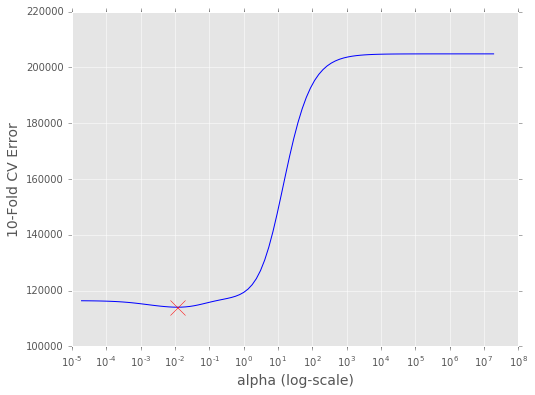

In [7]:
# Cross Validation Approach to Determine Best Alpha #
#####################################################
# scikit learns RidgeCV does not return cross-validation MSEs except for LOOCV case so we will custom write
# the cross validation procedure... In the Lasso Section we present another method that uses sklearn's cross
# validation package

alphas = 10**np.linspace(10,-2, 100)/(2*len(X))

# construct training and test folds
kf = KFold(len(X), n_folds=10)

cvs = []

for alpha in alphas:
    # For each shrinkage factor compute the models MSE for the 10-folds
    error = []
    
    for train, test in kf:
        # get test/train splits
        X_train = X.values[train]
        y_train = y.values[train]
        X_test = X.values[test]
        y_test = y.values[test]
        
        # build model for each split
        model = Ridge(alpha=alpha, normalize=True).fit(X_train,y_train)
        # compute error for this each response at this alpha for this fold
        error = np.append(error,(model.predict(X_test)-y_test))
        
    # compute mean squared error for this alpha
    cvs = np.append(cvs,np.mean(error**2))

# get the minimum alpha
min_index, min_cvs = min(enumerate(cvs), key=itemgetter(1)) 
print('Min Alpha, Min CV = ', alphas[min_index], min_cvs)

# Plot the CV Errors as a funtion of alpha and plot minimum
fig,ax = plt.subplots(figsize=(8,6))

ax.plot(alphas, cvs, color='b')
ax.plot(alphas[min_index], min_cvs, marker='x', color='r', markersize=15)

ax.set_xscale('log')
ax.set_ylabel('10-Fold CV Error', fontsize=14);
ax.set_xlabel('alpha (log-scale)', fontsize=14);

In [8]:
# Lastly, we can fit the full dataset with this value of alpha
regr = Ridge(alpha=alphas[min_index], normalize=True).fit(X,y)
df = pd.Series(data = np.hstack([regr.intercept_, regr.coef_]), index=['Intercept'] + X.columns.tolist())
df

Intercept      143.551508
AtBat           -1.522112
Hits             5.325030
HmRun            0.392076
Runs            -0.130377
RBI              0.134052
Walks            5.037902
Years          -10.599856
CAtBat          -0.046750
CHits            0.188898
CHmRun           0.695475
CRuns            0.640856
CRBI             0.367144
CWalks          -0.572358
PutOuts          0.278305
Assists          0.277635
Errors          -3.792163
League_N        60.861805
Division_W    -123.237678
NewLeague_N    -27.463695
dtype: float64

While the values here do not match the coeffecients from the text, the method is clear. We find the minimum in the CV curve across alphas and fit the full model with the best alpha. Fitting the shrinkage factor lambda exactly to glmnets results aren't really worth too much effort becasue the the exact values of the penalty are not useful, all we need to determine is the alpha/lambda that results in the lowest test MSE. When this is done, the best model in terms of bias/varaince trade-off has been located.

## 6.6.2 The Lasso

Scikit Learn's Lasso method minimizes the following objective function:

$\min \left(\frac{1}{2N}\sum_{i=1}^{N}{\left(y_i-\beta_0-\sum_{j=1}^{p}{\beta_jx_{i,j}}\right)}^2+\alpha\|\beta_j\|_1\right)$

Glmnets cost function with alpha set to 0 yields:

$\min \left(\frac{1}{2N}\sum_{i=1}^{N}{\left(y_i-\beta_0-\sum_{j=1}^{p}{\beta_jx_{i,j}}\right)}^2+\lambda\|\beta_j\|_1\right)$

So we expect the same results if we use a stadard scaling (i.e. center regressors and divide by std). This is automatically done by sklearn see https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/linear_model/base.py#L162

In [9]:
# set the values of alpha
grid = 10**np.linspace(10,-2,100)

np.random.seed(0)

# split the data into test and validation sets
train = np.random.choice([True, False], size=len(hitters))

X_train = X[train]
y_train = y[train]
X_test = X[~train]
y_test = y[~train]

coeffecients = np.empty((len(grid),X.shape[1]))

for index, alpha in enumerate(grid):
    # create model with normalize = False
    lasso = Lasso(alpha=alpha, normalize=False, max_iter=10000)
    
    # I made a pipeline so that later if I can hunt down the scaling 
    # problems I can easily include a transform of the predictors
    pipeline = Pipeline([('lasso', lasso)])
    
    # fit scaled training data model
    pipeline.fit(X_train, y_train)
    
    coeffecients[index] = lasso.coef_[np.newaxis]
    

## Plot Regression Coeffecients vs Lasso Penalty

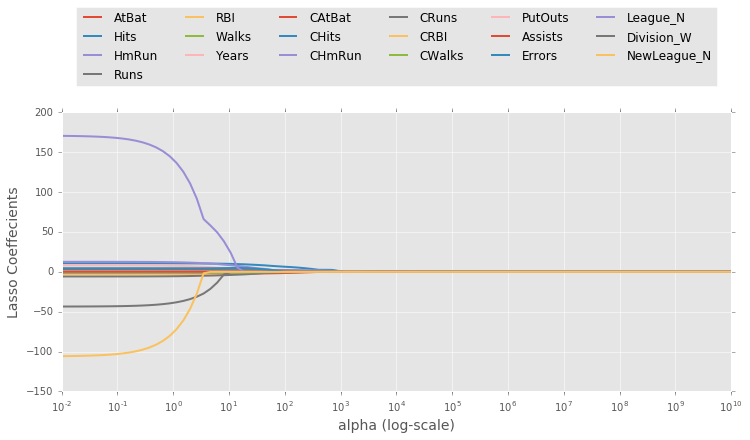

In [10]:
# Make a plot of the coeffecients   
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(grid, coeffecients, linewidth =2.0);

ax.set_xscale('log')
ax.set_xlabel('alpha (log-scale)', fontsize=14)
ax.set_ylabel('Lasso Coeffecients', fontsize=14)
ax.legend(X.columns.tolist(),loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=6);

## Use Cross Validation to Estimate Test MSE

Min Alpha =  132.194114847


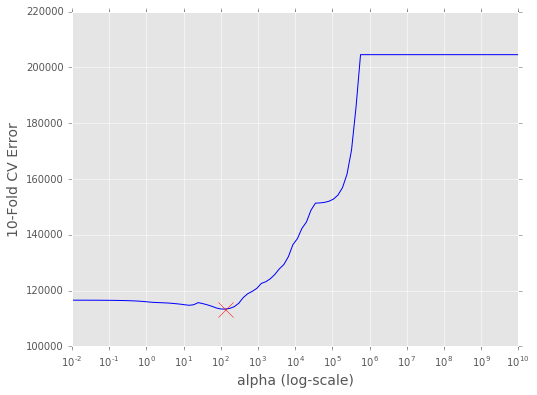

In [12]:
# Cross Validation to determine Optimum Alpha #
###############################################
# We now compute the best alpha, the one that minimize the Cross-Validation error.
# In the ridge regression part of this lab we did this by hand. Here we use sklearns
# cross-validation class.
scores = list()
np.random.seed(0)

# compute cross validation using MSE scoring
for alpha in grid:
    # for each alpha make a new model
    lasso = Lasso(alpha=alpha, normalize=False, max_iter=10000)
    
    # create our pipeline for later potential scaling of predictors
    pipeline = Pipeline([('lasso', lasso)])
    
    # get the cross-val score
    this_scores = -cross_validation.cross_val_score(pipeline, X, y, scoring='mean_squared_error', cv=10)
    scores.append(np.mean(this_scores))

# get the minimum alpha
min_index, min_score = min(enumerate(scores), key=itemgetter(1))
print('Min Alpha = ', grid[min_index])

# Plot the CV Errors as a funtion of alpha and plot minimum
fig,ax = plt.subplots(figsize=(8,6))

ax.plot(grid, scores, color='b')
ax.plot(grid[min_index], min_score, marker='x', color='r', markersize=15)

ax.set_xscale('log')
ax.set_ylabel('10-Fold CV Error', fontsize=14);
ax.set_xlabel('alpha (log-scale)', fontsize=14);

In [13]:
# We could also get the same result using LassoCV...
np.random.seed(0)
lasso_cv = LassoCV(alphas=alphas, max_iter=10000, cv=10)
lasso_cv.fit(X,y)
lasso_cv.alpha_

116.65222953256988

In [14]:
np.random.seed(0)

# split the data into test and validation sets
train = np.random.choice([True, False], size=len(hitters))

X_train = X[train]
y_train = y[train]
X_test = X[~train]
y_test = y[~train]

lasso = Lasso(alpha=grid[min_index], normalize=False, max_iter=10000)
lasso.fit(X_train, y_train)
        
mse = np.mean((lasso.predict(X_test)-y_test)**2)
df = pd.Series(data = np.hstack([lasso.intercept_, lasso.coef_]), index=['Intercept'] + X.columns.tolist())
print(df)

Intercept     -0.005858
AtBat         -1.185937
Hits           6.008471
HmRun          0.000000
Runs           0.000000
RBI            0.374117
Walks          0.838560
Years          0.000000
CAtBat        -0.068905
CHits         -0.271154
CHmRun         2.234522
CRuns          1.481198
CRBI          -0.043707
CWalks        -0.281609
PutOuts        0.336833
Assists        0.107696
Errors         0.000000
League_N       0.000000
Division_W    -0.000000
NewLeague_N    0.000000
dtype: float64
